In [1]:
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import bernoulli
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.manifold import MDS
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from typing import Literal


numpyro.set_platform('cpu')
numpyro.set_host_device_count(16)

In [2]:
kaggle_submission = False
run_cv = True

# Logistic Regression with Tree-based Features Selection and Sampler

In this experiment,
I'll try perform uncorrelated features removal
and Bayesian logistic regression.

## Data

In [3]:
if kaggle_submission:
    train_path = '/kaggle/input/icr-identify-age-related-conditions/train.csv'
    test_path = '/kaggle/input/icr-identify-age-related-conditions/test.csv'
else:
    train_path = '../data/train.csv'
    test_path = '../data/test.csv'

train_df = pd.read_csv(train_path)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [4]:
test_df = pd.read_csv(test_path)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5 non-null      object 
 1   AB      5 non-null      float64
 2   AF      5 non-null      float64
 3   AH      5 non-null      float64
 4   AM      5 non-null      float64
 5   AR      5 non-null      float64
 6   AX      5 non-null      float64
 7   AY      5 non-null      float64
 8   AZ      5 non-null      float64
 9   BC      5 non-null      float64
 10  BD      5 non-null      float64
 11  BN      5 non-null      float64
 12  BP      5 non-null      float64
 13  BQ      5 non-null      float64
 14  BR      5 non-null      float64
 15  BZ      5 non-null      float64
 16  CB      5 non-null      float64
 17  CC      5 non-null      float64
 18  CD      5 non-null      float64
 19  CF      5 non-null      float64
 20  CH      5 non-null      float64
 21  CL      5 non-null      float64
 22  CR    

### Data Preprocessing

In [5]:
imputer = SimpleImputer(strategy='median')
preprocessing = Pipeline([
    # ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

In [6]:
X_df = train_df.drop(columns=['Id', 'Class', 'EJ'])
y = train_df['Class']
ej = train_df['EJ'].astype('category')

X_df = pd.DataFrame(
    imputer.fit_transform(X_df),
    columns=X_df.columns,
    index=X_df.index)
y = y.values

### Interaction Terms

In [7]:
def create_interaction_terms_between(df: pd.DataFrame, features: list[str]):
    assert all(f in df.columns for f in features)

    interactions = dict()

    for i, fst in enumerate(features):
        for snd in features[i+1:]:
            interactions[f'{fst}*{snd}'] = df[fst] * df[snd]

    return pd.DataFrame(interactions)

### Quadratic Terms

In [8]:
def create_quadratic_terms(df: pd.DataFrame, features: list[str]):
    assert all(f in df.columns for f in features)

    return X_df[features].pow(2.).rename(columns={
        f: f'{f}^2' for f in features
    })

In [9]:
Xinteractions_df = create_interaction_terms_between(X_df, X_df.columns)
X2_df = create_quadratic_terms(X_df, X_df.columns)

Xtrain_df = pd.concat([X_df, Xinteractions_df, X2_df], axis=1)
# Xtrain_df['EJ'] = ej.cat.codes

### Correlations Removal

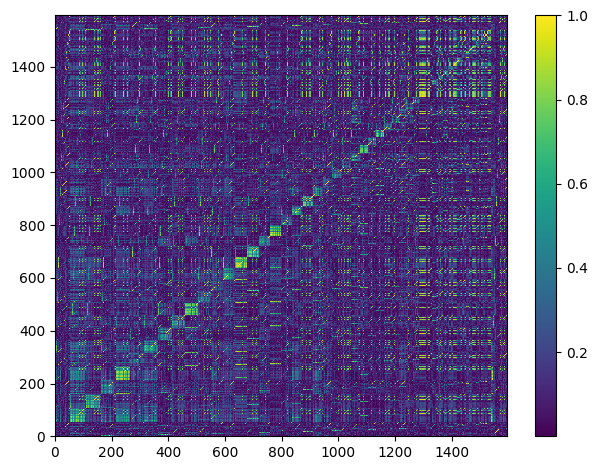

In [10]:
corr = Xtrain_df.corr('spearman')

fig, ax = plt.subplots()
cs = ax.pcolormesh(corr.abs())
fig.colorbar(cs, ax=ax)
fig.tight_layout()

/home/beekill/bin/mambaforge/envs/age/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<Axes: >

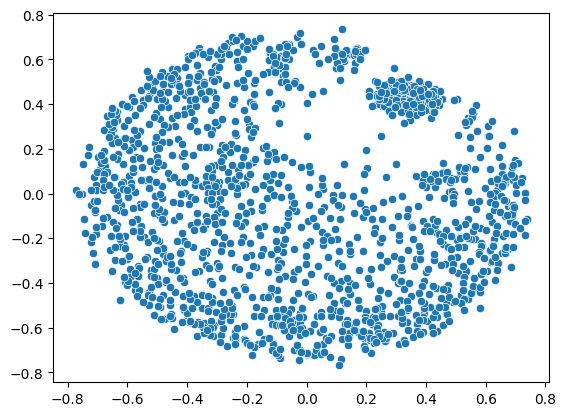

In [11]:
# Convert the correlation matrix into dissimilarity matrix,
# to be used with MDS.
distance = 1. - np.abs(corr)
mds = MDS(n_components=2, dissimilarity='precomputed')
embeddings = mds.fit_transform(distance)

# Show the results.
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1])

Clusters: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

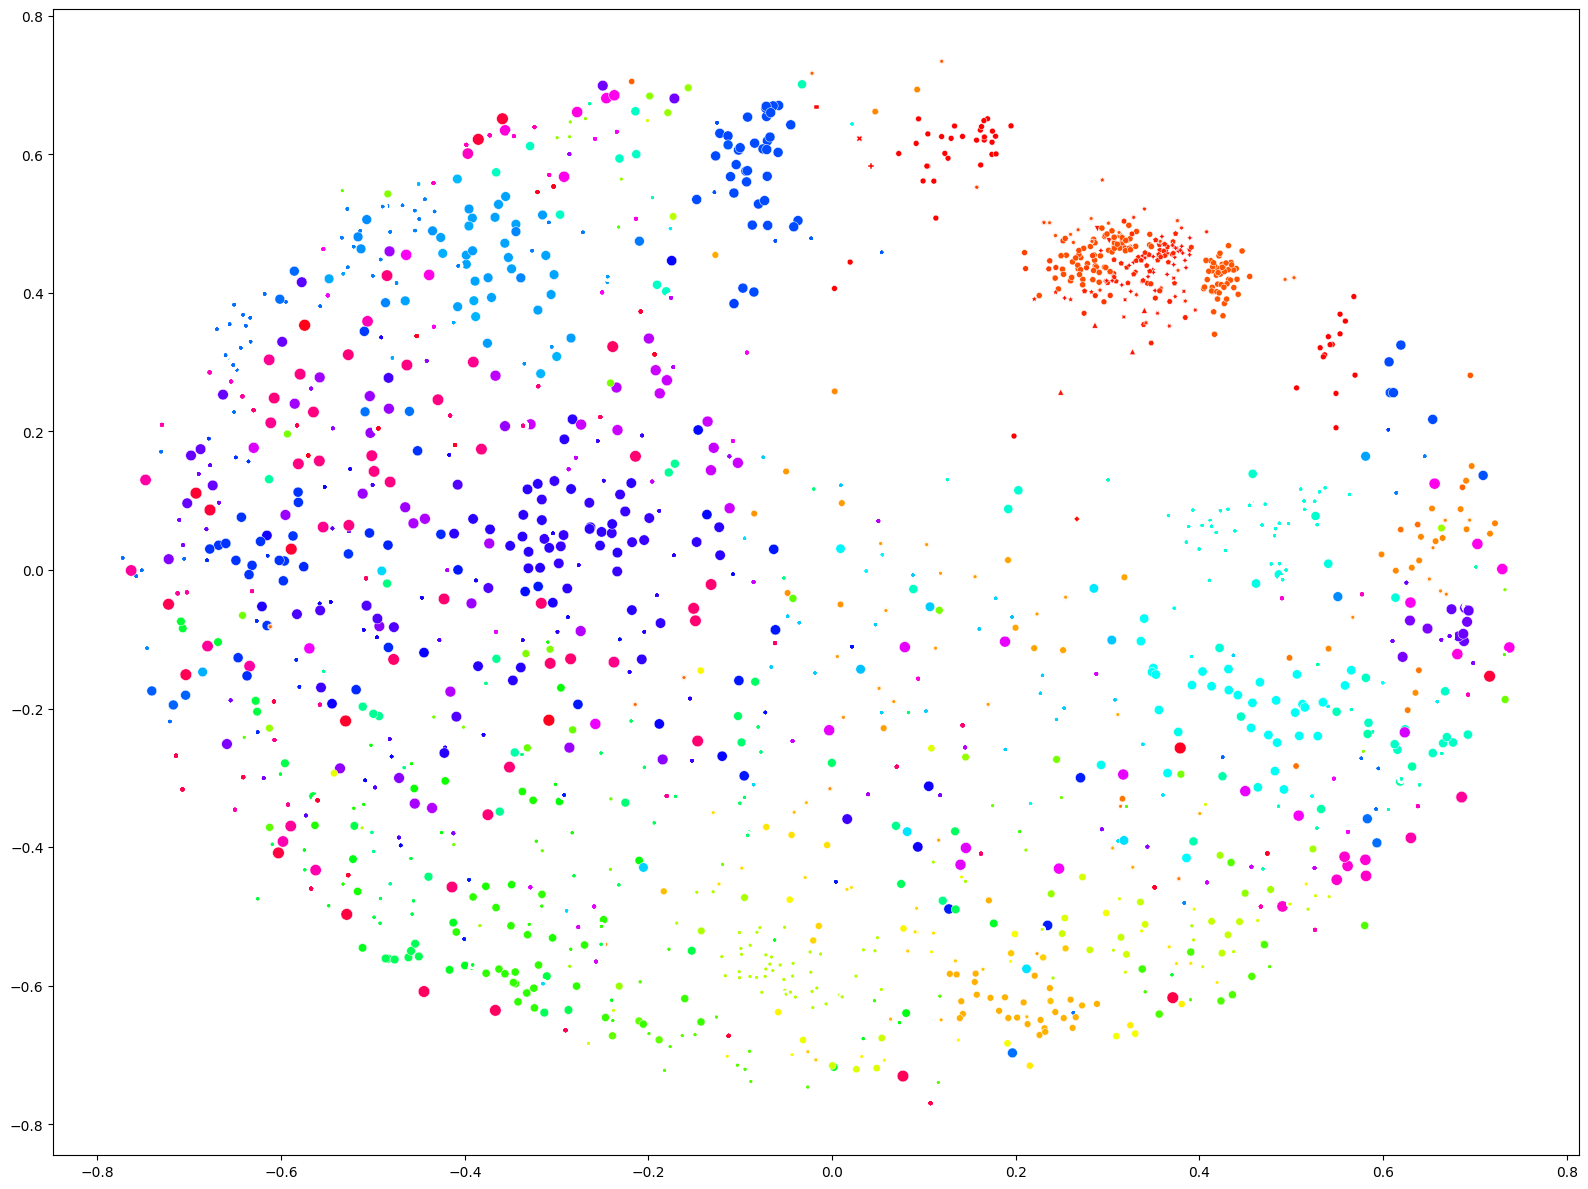

In [12]:
# Now, we can use clustering on the MDS's result
# to identify the clusters.
# clustering = DBSCAN(eps=0.1, min_samples=2, metric='precomputed')
# clusters = clustering.fit_predict(distance)
dist_linkage = hierarchy.ward(squareform(distance))
clusters = hierarchy.fcluster(dist_linkage, 0.3, criterion='distance')
unique_clusters = list(np.unique(clusters))
print(f'Clusters: {unique_clusters}')

# Plot the results.
fig, ax = plt.subplots(figsize=(16, 12))
sns.scatterplot(x=embeddings[:, 0],
                y=embeddings[:, 1],
                hue=clusters,
                style=clusters,
                size=clusters*100,
                palette='hsv',
                legend=False,
                ax=ax)
fig.tight_layout()

In [13]:
# Show the correlation in these clusters.
for cluster in unique_clusters:
    features_in_cluster = Xtrain_df.columns[clusters == cluster]
    X_in_cluster = Xtrain_df[features_in_cluster]
    corr_in_cluster = X_in_cluster.corr('spearman')
    corrs = 1 - squareform(1 - np.abs(corr_in_cluster))
    if len(features_in_cluster) > 1:
        print(f'{cluster=}, nb_features={len(features_in_cluster)}, '
              f'min={np.min(corrs)}, '
              f'max={np.max(corrs)}, mean={np.mean(corrs)}')
    else:
        print(f'{cluster=} has only 1 member.')

cluster=1, nb_features=47, min=0.6610663651465527, max=1.0, mean=0.8717003420133187
cluster=2 has only 1 member.
cluster=3 has only 1 member.
cluster=4 has only 1 member.
cluster=5 has only 1 member.
cluster=6, nb_features=33, min=0.853831339617906, max=1.0, mean=0.9147167073736575
cluster=7, nb_features=4, min=0.8476433715440829, max=0.9202469309244384, mean=0.8927511749537262
cluster=8, nb_features=4, min=0.8597206563102028, max=0.9462443710818355, mean=0.8991774649290855
cluster=9, nb_features=4, min=0.8537912907015649, max=0.9543980205027024, mean=0.902209830135333
cluster=10, nb_features=4, min=0.8893661261708603, max=0.9679051630992845, mean=0.927570034830481
cluster=11, nb_features=4, min=0.8697644756967174, max=0.958440050588756, mean=0.9072027141381702
cluster=12, nb_features=4, min=0.8761722038651139, max=0.9565649215041385, mean=0.9171461688673465
cluster=13, nb_features=38, min=0.8617061212929099, max=1.0, mean=0.925144595261086
cluster=14, nb_features=4, min=0.833351758802

Now, we can use these steps to extract the uncorrelated features.

In [14]:
def filter_in_uncorrelated_features(X_df: pd.DataFrame,
                                    correlation_threshold: float = 0.7):
    # Calculate Spearman's correlation, and then convert to
    # distances matrix.
    corr = X_df.corr('spearman')
    distances = 1. - corr.abs()

    # Perform clustering using Agglomerative Clustering.
    dist_linkage = hierarchy.ward(squareform(distances))
    clusters = hierarchy.fcluster(dist_linkage,
                                  1. - correlation_threshold,
                                  criterion='distance')

    # Choose a feature from each cluster.
    features = []
    for cluster in np.unique(clusters):
        features_in_cluster = X_df.columns[cluster == clusters]

        # TODO: Here, we use the first feature,
        # but it can be other choices.
        chosen_feature = features_in_cluster[0]
        features.append(chosen_feature)

    # Return a new dataframe with the chosen features.
    return X_df[features]

## Model
### Neural Network Classifier

In [15]:
class NNClassifier(nn.Module):
    def __init__(self, input_shape: int) -> None:
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Dropout(),
            nn.LayerNorm(1024),

            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(),
            nn.LayerNorm(512),

            nn.Linear(512, 64),
            # nn.Tanh(),
        )

        self.guess_prob = nn.Parameter(
            torch.randn(1),
            requires_grad=True)

        self.output = nn.Sequential(
            # nn.Dropout(),
            nn.LayerNorm(64),
            # nn.Dropout(),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, *,
                mode: Literal['encoder', 'output', 'full'] = 'full'):
        if mode == 'encoder':
            return self.encoder(x)
        elif mode == 'output':
            return self._calculate_prob(x)
        elif mode == 'full':
            x = self.encoder(x)
            return self._calculate_prob(x)

        raise ValueError(f'Unknown mode={mode}')

    def _calculate_prob(self, x):
        prob = self.output(x)
        guess_prob = torch.sigmoid(self.guess_prob)
        return (1 - guess_prob) * prob + 0.5 * guess_prob


def create_training_and_evaluation_step(
        model: nn.Module,
        lr=1e-3,
        weight_decay=1e-5,
        regularization_weight=1e-2):

    loss_fn = nn.BCELoss()

    optimizer = torch.optim.Adam(
        model.parameters(), lr=lr, weight_decay=weight_decay)

    # Init weights before training.
    def init_weights(m: nn.Module):
        strategy_fn = nn.init.xavier_normal_
        if type(m) in [nn.Linear, nn.LazyLinear]:
            strategy_fn(m.weight)

    model.apply(lambda m: init_weights(m))

    def encoder_regularization_loss(x: torch.Tensor):
        """
        Calculate regularization loss of the encoder's output.

        x should have shape (nb_batches, nb_features)
        """
        # First, the output should be normally distributed.
        l1 = torch.mean(torch.sum(x**2, axis=1))

        # Second, features should not be correlated.
        cov = torch.t(x) @ x
        cov = cov - torch.diag(torch.diag(cov))
        l2 = torch.mean(torch.abs(cov))

        return l1 + l2

    def train_step(dataloader: DataLoader, *,
                   device: str, epoch: int, progress: bool = True,
                   train_noise: float = 0.0):
        model.train()

        train_loss = 0
        regularization_loss = 0

        num_batches = len(dataloader)
        bar = (tqdm(
            enumerate(dataloader), total=num_batches, desc=f'Epoch {epoch}')
            if progress
            else enumerate(dataloader))
        for i, (X, y) in bar:
            X, y = X.to(device), y.to(device)

            # Add noise to the training.
            X = X + train_noise * torch.rand_like(X)

            # Make prediction and calculate loss.
            encoder_output = model(X, mode='encoder')
            pred = model(encoder_output, mode='output')

            # Losses.
            encoder_loss = encoder_regularization_loss(encoder_output)
            classification_loss = loss_fn(pred, y)

            loss = regularization_weight * encoder_loss + classification_loss
            regularization_loss += encoder_loss.item()
            train_loss += loss.item()

            # Back-propagation step.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Show the MSE.
            if progress:
                bar.set_postfix_str(
                    f'Loss: {(train_loss / (i + 1)):.4f}'
                    f'- Encoder loss: {regularization_loss / (i + 1):.4f}')

        return train_loss / num_batches, regularization_loss / num_batches

    def evaluate_step(dataloader: DataLoader, device: str):
        num_batches = len(dataloader)
        model.eval()

        test_loss = 0
        regularization_loss = 0

        with torch.no_grad():
            for i, (X, y) in enumerate(dataloader):
                X, y = X.to(device), y.to(device)

                encoder_output = model(X, mode='encoder')
                pred = model(encoder_output, mode='output')

                encoder_loss = encoder_regularization_loss(
                    encoder_output).item()
                regularization_loss += encoder_loss
                test_loss += (loss_fn(pred, y).item()
                              + regularization_weight * encoder_loss)

        test_loss /= num_batches
        return test_loss, regularization_loss / num_batches

    return train_step, evaluate_step


def train(model: nn.Module,
          *,
          train_ds: DataLoader,
          val_ds: DataLoader,
          epochs: int,
          train_noise: float = 0.0,
          early_stopping_patience: int = 100,
          device: str = 'cpu',
          lr: float = 1e-3,
          weight_decay: float = 1e-2,
          regularization_weight: float = 1.0):
    def save_checkpoint(model, path):
        torch.save(model.state_dict(), path)

    def load_checkpoint(model, path):
        model.load_state_dict(torch.load(path))
        return model

    model = model.to(device)

    train_step, val_step = create_training_and_evaluation_step(
        model,
        lr=lr,
        weight_decay=weight_decay,
        regularization_weight=regularization_weight)
    train_losses = []
    val_losses = []

    tmp_path = 'tmp_autoencoder.pth'

    patience = 0
    bar = tqdm(range(epochs), total=epochs, desc='Training')
    for epoch in bar:
        train_loss, train_regu_loss = train_step(
            train_ds, device=device, epoch=epoch, progress=False,
            train_noise=train_noise)
        train_losses.append(train_loss)

        val_loss, val_regu_loss = val_step(val_ds, device)
        val_losses.append(val_loss)

        bar.set_postfix_str(
            f'Train: {train_loss:.4f} - Val: {val_loss:.4f}'
            f'-Train Reg: {train_regu_loss:.4f} - Val Reg:{val_regu_loss:.4f}')

        patience += 1
        if val_loss <= np.min(val_losses):
            save_checkpoint(model, tmp_path)
            patience = 0
        else:
            if patience > early_stopping_patience:
                print(f'The validation does not improve for the last {patience} epochs. '
                      'Early stopping!')
                break

    # Best validation score and corresponding train score.
    best_val_idx = np.argmin(val_losses)
    print(
        f'Train: {train_losses[best_val_idx]:.4f} '
        f'- Val: {val_losses[best_val_idx]:.4f} at epoch {best_val_idx}.')

    # Restore the best model.
    print('Restore the best model.')
    return (load_checkpoint(model, tmp_path),
            dict(train_loss=train_losses,
                 val_loss=val_losses,
                 best_epoch=best_val_idx))

### Features Selection

In [16]:
def select_important_features(
        X, y, *, n_estimators: int = 50, important_thresholds: float = 0.5):
    model = ExtraTreesClassifier(n_estimators=n_estimators)
    model.fit(X, y)
    print(model.feature_importances_)
    selector = SelectFromModel(
        model,
        prefit=True,
        threshold=important_thresholds)
    x = selector.fit_transform(X, y)
    return pd.DataFrame(x, columns=selector.get_feature_names_out())

### Oversampling

In [17]:
def sampling(X, y):
    ros = SMOTENC(['ej'], sampling_strategy='all', random_state=0)
    columns = X.columns
    x, y = ros.fit_resample(X, y)
    return pd.DataFrame(x, columns=columns), y

### Cross Validation

In [18]:
def balanced_log_loss(y_true, pred_prob):
    nb_class_0 = np.sum(1 - y_true)
    nb_class_1 = np.sum(y_true)

    prob_0 = np.clip(1. - pred_prob, 1e-10, 1. - 1e-10)
    prob_1 = np.clip(pred_prob, 1e-10, 1. - 1e-10)
    return (-np.sum((1 - y_true) * np.log(prob_0)) / nb_class_0
            - np.sum(y_true * np.log(prob_1)) / nb_class_1) / 2.


def calculate_optimal_prob_prediction(y_preds):
    """
    Calculate the best probability prediction based on the formula
    (in experiment 04_logistics_bayesian_v4*).

    y_preds: numpy array of shape (nb_draws, nb_data_points).
    """
    assert y_preds.ndim == 2, "Only accept 2d numpy array as input."
    _, nb_data = y_preds.shape
    print(y_preds.shape)

    # Calculate number of classes for each draw.
    nb_class_0 = np.sum(1 - y_preds, axis=1)
    print(nb_class_0.shape)
    nb_class_1 = np.sum(y_preds, axis=1)

    best_probs = []
    eps = 1e-15
    for j in range(nb_data):
        cj = np.sum(y_preds[:, j] / (nb_class_1 + eps))
        cj_1 = np.sum((1 - y_preds[:, j]) / (nb_class_0 + eps))

        prob = cj / (cj + cj_1)
        best_probs.append(prob)

    return np.asarray(best_probs)


def estimate_optimal_prob_pred(y_prob, nb_samples: int = 20000):
    ys = bernoulli.rvs(y_prob[:, None], size=(y_prob.shape[0], nb_samples))
    return calculate_optimal_prob_prediction(ys.T)


def f1_recall_precision(y_true, y_pred):
    return tuple(f(y_true, y_pred)
                 for f in [f1_score, recall_score, precision_score])


def plot_train_history(history: dict, epochs: int):
    fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')

    train_loss = history['train_loss']
    val_loss = history['val_loss']

    epochs = list(range(len(train_loss)))
    ax.plot(epochs, train_loss, label='Train Loss')
    ax.plot(epochs, val_loss, label='Val Loss')
    ax.vlines(
        history['best_epoch'],
        ymin=min(min(train_loss), min(val_loss)),
        ymax=max(max(train_loss), max(val_loss)),
        label='Best epoch',
        linestyles='dashed')
    ax.legend()

    return fig


def train_and_evaluate(*,
                       Xtr, gtr, ytr,
                       Xte, gte, yte,
                       epochs: int = 100,
                       device: str = 'cpu',
                       lr: float = 1e-3,
                       train_noise: float = 0.0,
                       early_stopping_patience: int = 100,
                       correlation_threshold: float = 0.3,
                       weight_decay: float = 1e-2,
                       regularization_weight: float = 1.0):
    # First, we will normalize the data.
    Xtr = pd.DataFrame(
        preprocessing.fit_transform(Xtr, ytr),
        columns=Xtr.columns)
    Xte = pd.DataFrame(
        preprocessing.transform(Xte),
        columns=Xte.columns)

    # Next, we'll filter out correlated features.
    Xtr = filter_in_uncorrelated_features(
        Xtr, correlation_threshold=correlation_threshold)
    Xte = Xte[Xtr.columns]

    # Store original training dataset.
    Xtr_orig = Xtr.copy()
    Xtr_orig['ej'] = gtr
    ytr_orig = ytr.copy()
    print(f'Before sampling, has {len(ytr_orig)} sammples,\n'
          f'in which there are {ytr_orig.sum()} positive samples.')

    # Next, we'll perform sampling.
    Xtr['ej'] = gtr
    Xte['ej'] = gte

    Xtr, ytr = sampling(Xtr, ytr)
    print(f'After sampling, has {len(ytr)} sammples,\n'
          f'in which there are {ytr.sum()} positive samples.')

    # Then, we use tree-based model to select important features.
    # Xtr = select_important_features(
    #     Xtr, ytr,
    #     n_estimators=1000,
    #     important_thresholds='5*median')
    # Xte = Xte[Xtr.columns]
    nb_features = len(Xtr.columns)
    print('Number of important features: ', nb_features)

    # Training neural network model.
    # print(Xtr.values, ytr[:, None])
    X_train_ds = TensorDataset(
        torch.tensor(Xtr.values, dtype=torch.float32),
        torch.tensor(ytr[:, None], dtype=torch.float32))
    X_val_ds = TensorDataset(
        torch.tensor(Xte.values, dtype=torch.float32),
        torch.tensor(yte[:, None], dtype=torch.float32))

    Xtr_dataloader = DataLoader(X_train_ds, batch_size=64, shuffle=True)
    Xva_dataloader = DataLoader(X_val_ds, batch_size=64)

    model, history = train(NNClassifier(nb_features),
                           train_ds=Xtr_dataloader,
                           val_ds=Xva_dataloader,
                           epochs=epochs,
                           early_stopping_patience=early_stopping_patience,
                           device=device,
                           lr=lr,
                           weight_decay=weight_decay,
                           regularization_weight=regularization_weight,
                           train_noise=train_noise)

    # Plot training history.
    # fig = plot_train_history(history, epochs=epochs)
    # plt.show()
    # plt.close(fig)

    # Evaluate the model.
    ytr_prob = (model(
        torch.tensor(Xtr_orig.values, dtype=torch.float32).to(device))
        .cpu().detach().numpy().squeeze())
    ytr_opt_prob = estimate_optimal_prob_pred(ytr_prob)
    ytr_pred = np.where(ytr_prob > 0.5, 1., 0.)
    (f1_train,
     recall_train,
     precision_train) = f1_recall_precision(ytr_orig, ytr_pred)
    log_loss_train = balanced_log_loss(ytr_orig, ytr_prob)
    opt_log_loss_train = balanced_log_loss(ytr_orig, ytr_opt_prob)
    print(f'Train - f1={f1_train:.4f} recall={recall_train:.4f} '
          f'precision={precision_train:.4f} log-loss={log_loss_train:.4f} '
          f'opt-log-loss={opt_log_loss_train:.4f}')

    yte_prob = (model(
        torch.tensor(Xte.values, dtype=torch.float32).to(device))
        .cpu().detach().numpy().squeeze())
    yte_opt_prob = estimate_optimal_prob_pred(yte_prob)
    yte_pred = np.where(yte_prob > 0.5, 1., 0.)
    (f1_test,
     recall_test,
     precision_test) = f1_recall_precision(yte, yte_pred)
    log_loss_test = balanced_log_loss(yte, yte_prob)
    opt_log_loss_test = balanced_log_loss(yte, yte_opt_prob)
    print(f'Test  - f1={f1_test:.4f} recall={recall_test:.4f} '
          f'precision={precision_test:.4f} log-loss={log_loss_test:.4f} '
          f'opt-log-loss={opt_log_loss_test:.4f}')

    return dict(
        f1_train=f1_train,
        f1_test=f1_test,
        log_loss_train=log_loss_train,
        opt_log_loss_train=opt_log_loss_train,
        log_loss_test=log_loss_test,
        opt_log_loss_test=opt_log_loss_test,
    )


def cross_validations(*, X, grp, y,
                      n_folds: int = 10,
                      repeats_per_fold: int = 1,
                      **kwargs):
    results = []

    kfolds = StratifiedKFold(n_splits=n_folds)
    for fold, (train_idx, test_idx) in enumerate(kfolds.split(X, y)):
        for repeat in range(repeats_per_fold):
            print(f'\n-- Fold # {fold + 1}/{n_folds} - '
                  f'Repeat #{repeat + 1}/{repeats_per_fold}:')

            Xtr, Xte = X.iloc[train_idx], X.iloc[test_idx]
            gtr, gte = grp[train_idx], grp[test_idx]
            ytr, yte = y[train_idx], y[test_idx]

            result = train_and_evaluate(
                Xtr=Xtr, gtr=gtr, ytr=ytr,
                Xte=Xte, gte=gte, yte=yte,
                **kwargs)

            result['fold'] = fold + 1
            result['repeat'] = repeat + 1
            results.append(result)

    return pd.DataFrame(results)


cv_results = cross_validations(
    X=Xtrain_df,
    grp=ej.cat.codes.values,
    y=y,
    n_folds=10,
    repeats_per_fold=10,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    epochs=2000,
    correlation_threshold=0.3,
    lr=1e-4,
    early_stopping_patience=100,
    weight_decay=1e-2,
    regularization_weight=1.0,
    train_noise=0.01)


-- Fold # 1/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0948 - Val: 0.2794 at epoch 498.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.0534 opt-log-loss=0.1007
(20000, 62)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.3601 opt-log-loss=0.3263

-- Fold # 1/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2474 - Val: 0.3359 at epoch 799.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2403 opt-log-loss=0.2914
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.4384 opt-log-loss=0.4374

-- Fold # 1/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2453 - Val: 0.2894 at epoch 387.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9694 recall=0.9794 precision=0.9596 log-loss=0.1711 opt-log-loss=0.2271
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3278 opt-log-loss=0.3339

-- Fold # 1/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1851 - Val: 0.2340 at epoch 466.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.1382 opt-log-loss=0.1982
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2533 opt-log-loss=0.2806

-- Fold # 1/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2333 - Val: 0.2782 at epoch 356.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9592 recall=0.9691 precision=0.9495 log-loss=0.1442 opt-log-loss=0.1973
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3358 opt-log-loss=0.3264

-- Fold # 1/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1801 - Val: 0.2736 at epoch 444.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.1221 opt-log-loss=0.1789
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3637 opt-log-loss=0.3335

-- Fold # 1/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2204 - Val: 0.3178 at epoch 870.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2175 opt-log-loss=0.2726
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3872 opt-log-loss=0.4013

-- Fold # 1/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3111 - Val: 0.3411 at epoch 445.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9845 recall=0.9794 precision=0.9896 log-loss=0.2594 opt-log-loss=0.3059
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3722 opt-log-loss=0.3840

-- Fold # 1/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1307 - Val: 0.2079 at epoch 476.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0886 opt-log-loss=0.1396
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.2406 opt-log-loss=0.2341

-- Fold # 1/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  83


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2585 - Val: 0.2942 at epoch 474.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9796 recall=0.9897 precision=0.9697 log-loss=0.2153 opt-log-loss=0.2699
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3160 opt-log-loss=0.3375

-- Fold # 2/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1632 - Val: 0.2556 at epoch 607.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1430 opt-log-loss=0.2063
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2924 opt-log-loss=0.3107

-- Fold # 2/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1193 - Val: 0.1889 at epoch 1430.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1167 opt-log-loss=0.1798
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2333 opt-log-loss=0.2606

-- Fold # 2/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1734 - Val: 0.2644 at epoch 732.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1527 opt-log-loss=0.2156
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3434 opt-log-loss=0.3457

-- Fold # 2/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1905 - Val: 0.2431 at epoch 1221.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1867 opt-log-loss=0.2458
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2749 opt-log-loss=0.3093

-- Fold # 2/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2008 - Val: 0.2619 at epoch 1281.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1979 opt-log-loss=0.2559
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.3136 opt-log-loss=0.3364

-- Fold # 2/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1521 - Val: 0.2165 at epoch 1177.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.1501 opt-log-loss=0.2132
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2636 opt-log-loss=0.2908

-- Fold # 2/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1080 - Val: 0.1812 at epoch 1531.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1055 opt-log-loss=0.1676
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2288 opt-log-loss=0.2547

-- Fold # 2/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1303 - Val: 0.1967 at epoch 881.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1201 opt-log-loss=0.1833
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2380 opt-log-loss=0.2662

-- Fold # 2/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0991 - Val: 0.1794 at epoch 1447.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0951 opt-log-loss=0.1558
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2412 opt-log-loss=0.2546

-- Fold # 2/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0456 - Val: 0.1495 at epoch 1106.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0421 opt-log-loss=0.0832
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2174 opt-log-loss=0.2118

-- Fold # 3/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1671 - Val: 0.2282 at epoch 1109.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1640 opt-log-loss=0.2260
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.2659 opt-log-loss=0.2997

-- Fold # 3/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1411 - Val: 0.2715 at epoch 626.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1202 opt-log-loss=0.1828
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3521 opt-log-loss=0.3530

-- Fold # 3/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1713 - Val: 0.2754 at epoch 656.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1544 opt-log-loss=0.2168
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3491 opt-log-loss=0.3556

-- Fold # 3/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1679 - Val: 0.3059 at epoch 396.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.0976 opt-log-loss=0.1486
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3206 opt-log-loss=0.3220

-- Fold # 3/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2493 - Val: 0.2877 at epoch 1176.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2447 opt-log-loss=0.2949
(20000, 62)
(20000,)
Test  - f1=0.9091 recall=0.9091 precision=0.9091 log-loss=0.3046 opt-log-loss=0.3379

-- Fold # 3/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1453 - Val: 0.2801 at epoch 578.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1069 opt-log-loss=0.1656
(20000, 62)
(20000,)
Test  - f1=0.7368 recall=0.6364 precision=0.8750 log-loss=0.4533 opt-log-loss=0.3867

-- Fold # 3/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1377 - Val: 0.2691 at epoch 575.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9948 recall=0.9897 precision=1.0000 log-loss=0.1070 opt-log-loss=0.1632
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3317 opt-log-loss=0.3262

-- Fold # 3/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2255 - Val: 0.2990 at epoch 862.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2175 opt-log-loss=0.2722
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.3251 opt-log-loss=0.3548

-- Fold # 3/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1457 - Val: 0.2639 at epoch 549.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1158 opt-log-loss=0.1779
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.3534 opt-log-loss=0.3387

-- Fold # 3/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1486 - Val: 0.2661 at epoch 588.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9948 recall=0.9897 precision=1.0000 log-loss=0.1291 opt-log-loss=0.1874
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3575 opt-log-loss=0.3496

-- Fold # 4/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2235 - Val: 0.3062 at epoch 797.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2172 opt-log-loss=0.2719
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.3174 opt-log-loss=0.3478

-- Fold # 4/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1628 - Val: 0.2934 at epoch 697.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1446 opt-log-loss=0.2075
(20000, 62)
(20000,)
Test  - f1=0.8333 recall=0.9091 precision=0.7692 log-loss=0.3153 opt-log-loss=0.3390

-- Fold # 4/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1902 - Val: 0.3074 at epoch 767.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1783 opt-log-loss=0.2384
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.4216 opt-log-loss=0.4113

-- Fold # 4/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2283 - Val: 0.3416 at epoch 403.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9792 recall=0.9691 precision=0.9895 log-loss=0.1884 opt-log-loss=0.2408
(20000, 62)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3735 opt-log-loss=0.3824

-- Fold # 4/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1997 - Val: 0.2758 at epoch 586.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9948 recall=0.9897 precision=1.0000 log-loss=0.1687 opt-log-loss=0.2284
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2969 opt-log-loss=0.3246

-- Fold # 4/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0828 - Val: 0.2042 at epoch 877.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0724 opt-log-loss=0.1270
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2354 opt-log-loss=0.2555

-- Fold # 4/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1164 - Val: 0.2638 at epoch 646.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9948 recall=0.9897 precision=1.0000 log-loss=0.0995 opt-log-loss=0.1553
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3384 opt-log-loss=0.3338

-- Fold # 4/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3270 - Val: 0.3609 at epoch 1685.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.3240 opt-log-loss=0.3594
(20000, 62)
(20000,)
Test  - f1=0.9000 recall=0.8182 precision=1.0000 log-loss=0.4136 opt-log-loss=0.4257

-- Fold # 4/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1812 - Val: 0.2628 at epoch 1058.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1689 opt-log-loss=0.2304
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2821 opt-log-loss=0.3167

-- Fold # 4/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2190 - Val: 0.3013 at epoch 776.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.2070 opt-log-loss=0.2634
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3569 opt-log-loss=0.3732

-- Fold # 5/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2141 - Val: 0.2693 at epoch 1570.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2101 opt-log-loss=0.2661
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3166 opt-log-loss=0.3411

-- Fold # 5/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2583 - Val: 0.2571 at epoch 332.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9057 recall=0.9897 precision=0.8348 log-loss=0.1387 opt-log-loss=0.2005
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3162 opt-log-loss=0.3051

-- Fold # 5/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1879 - Val: 0.2649 at epoch 872.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1752 opt-log-loss=0.2360
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3438 opt-log-loss=0.3553

-- Fold # 5/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2568 - Val: 0.2586 at epoch 334.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.8649 recall=0.9897 precision=0.7680 log-loss=0.1797 opt-log-loss=0.2414
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2308 opt-log-loss=0.2650

-- Fold # 5/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1477 - Val: 0.2577 at epoch 690.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1347 opt-log-loss=0.1979
(20000, 62)
(20000,)
Test  - f1=0.8000 recall=0.7273 precision=0.8889 log-loss=0.4140 opt-log-loss=0.3788

-- Fold # 5/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0710 - Val: 0.1998 at epoch 1206.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0608 opt-log-loss=0.1118
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3413 opt-log-loss=0.3047

-- Fold # 5/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3314 - Val: 0.3112 at epoch 394.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9187 recall=0.9897 precision=0.8571 log-loss=0.2613 opt-log-loss=0.3098
(20000, 62)
(20000,)
Test  - f1=0.8571 recall=0.8182 precision=0.9000 log-loss=0.3202 opt-log-loss=0.3449

-- Fold # 5/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2699 - Val: 0.3140 at epoch 906.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2613 opt-log-loss=0.3085
(20000, 62)
(20000,)
Test  - f1=0.9000 recall=0.8182 precision=1.0000 log-loss=0.3765 opt-log-loss=0.3929

-- Fold # 5/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2891 - Val: 0.2989 at epoch 361.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.8962 recall=0.9794 precision=0.8261 log-loss=0.2175 opt-log-loss=0.2735
(20000, 62)
(20000,)
Test  - f1=0.8696 recall=0.9091 precision=0.8333 log-loss=0.2814 opt-log-loss=0.3115

-- Fold # 5/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  77


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3391 - Val: 0.3124 at epoch 294.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.8297 recall=0.9794 precision=0.7197 log-loss=0.2141 opt-log-loss=0.2723
(20000, 62)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.3132 opt-log-loss=0.3280

-- Fold # 6/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0684 - Val: 0.3109 at epoch 692.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0557 opt-log-loss=0.1039
(20000, 62)
(20000,)
Test  - f1=0.7059 recall=0.5455 precision=1.0000 log-loss=0.7090 opt-log-loss=0.4780

-- Fold # 6/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2401 - Val: 0.3488 at epoch 826.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.2308 opt-log-loss=0.2835
(20000, 62)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4448 opt-log-loss=0.4434

-- Fold # 6/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1459 - Val: 0.2713 at epoch 893.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1326 opt-log-loss=0.1959
(20000, 62)
(20000,)
Test  - f1=0.7778 recall=0.6364 precision=1.0000 log-loss=0.4907 opt-log-loss=0.4175

-- Fold # 6/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2023 - Val: 0.3697 at epoch 579.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.1807 opt-log-loss=0.2404
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.5455 precision=0.8571 log-loss=0.5803 opt-log-loss=0.5086

-- Fold # 6/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1711 - Val: 0.2960 at epoch 886.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1649 opt-log-loss=0.2267
(20000, 62)
(20000,)
Test  - f1=0.7368 recall=0.6364 precision=0.8750 log-loss=0.4861 opt-log-loss=0.4378

-- Fold # 6/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2367 - Val: 0.3466 at epoch 843.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.2328 opt-log-loss=0.2854
(20000, 62)
(20000,)
Test  - f1=0.7368 recall=0.6364 precision=0.8750 log-loss=0.4900 opt-log-loss=0.4686

-- Fold # 6/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1231 - Val: 0.2386 at epoch 1077.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1127 opt-log-loss=0.1752
(20000, 62)
(20000,)
Test  - f1=0.8421 recall=0.7273 precision=1.0000 log-loss=0.4162 opt-log-loss=0.3726

-- Fold # 6/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2476 - Val: 0.3902 at epoch 543.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.2167 opt-log-loss=0.2701
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.6364 precision=0.7000 log-loss=0.5213 opt-log-loss=0.4891

-- Fold # 6/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1538 - Val: 0.3410 at epoch 751.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.1436 opt-log-loss=0.2065
(20000, 62)
(20000,)
Test  - f1=0.7000 recall=0.6364 precision=0.7778 log-loss=0.5319 opt-log-loss=0.4683

-- Fold # 6/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3075 - Val: 0.4052 at epoch 386.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9447 recall=0.9691 precision=0.9216 log-loss=0.2479 opt-log-loss=0.2963
(20000, 62)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.4686 opt-log-loss=0.4626

-- Fold # 7/10 - Repeat #1/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1799 - Val: 0.4044 at epoch 447.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9738 recall=0.9588 precision=0.9894 log-loss=0.1562 opt-log-loss=0.2072
(20000, 62)
(20000,)
Test  - f1=0.6000 recall=0.5455 precision=0.6667 log-loss=0.6422 opt-log-loss=0.5310

-- Fold # 7/10 - Repeat #2/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3560 - Val: 0.4654 at epoch 700.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9948 recall=0.9897 precision=1.0000 log-loss=0.3534 opt-log-loss=0.3835
(20000, 62)
(20000,)
Test  - f1=0.5556 recall=0.4545 precision=0.7143 log-loss=0.6017 opt-log-loss=0.5785

-- Fold # 7/10 - Repeat #3/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1438 - Val: 0.3412 at epoch 748.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1341 opt-log-loss=0.1973
(20000, 62)
(20000,)
Test  - f1=0.6250 recall=0.4545 precision=1.0000 log-loss=0.6620 opt-log-loss=0.5187

-- Fold # 7/10 - Repeat #4/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3239 - Val: 0.4036 at epoch 236.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9254 recall=0.9588 precision=0.8942 log-loss=0.1484 opt-log-loss=0.1610
(20000, 62)
(20000,)
Test  - f1=0.6316 recall=0.5455 precision=0.7500 log-loss=0.7267 opt-log-loss=0.5153

-- Fold # 7/10 - Repeat #5/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1668 - Val: 0.3685 at epoch 722.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1555 opt-log-loss=0.2180
(20000, 62)
(20000,)
Test  - f1=0.5882 recall=0.4545 precision=0.8333 log-loss=0.6583 opt-log-loss=0.5417

-- Fold # 7/10 - Repeat #6/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2498 - Val: 0.4265 at epoch 333.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9538 recall=0.9588 precision=0.9490 log-loss=0.1677 opt-log-loss=0.2144
(20000, 62)
(20000,)
Test  - f1=0.4706 recall=0.3636 precision=0.6667 log-loss=0.6699 opt-log-loss=0.5358

-- Fold # 7/10 - Repeat #7/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2011 - Val: 0.4256 at epoch 366.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9637 recall=0.9588 precision=0.9688 log-loss=0.1682 opt-log-loss=0.2051
(20000, 62)
(20000,)
Test  - f1=0.5714 recall=0.5455 precision=0.6000 log-loss=0.6860 opt-log-loss=0.5502

-- Fold # 7/10 - Repeat #8/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2159 - Val: 0.3701 at epoch 777.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9898 log-loss=0.2078 opt-log-loss=0.2642
(20000, 62)
(20000,)
Test  - f1=0.6316 recall=0.5455 precision=0.7500 log-loss=0.5643 opt-log-loss=0.5089

-- Fold # 7/10 - Repeat #9/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1623 - Val: 0.3806 at epoch 831.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1555 opt-log-loss=0.2179
(20000, 62)
(20000,)
Test  - f1=0.5556 recall=0.4545 precision=0.7143 log-loss=0.6685 opt-log-loss=0.5545

-- Fold # 7/10 - Repeat #10/10:
Before sampling, has 555 sammples,
in which there are 97 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  78


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2795 - Val: 0.3962 at epoch 880.
Restore the best model.
(20000, 555)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2713 opt-log-loss=0.3164
(20000, 62)
(20000,)
Test  - f1=0.6667 recall=0.5455 precision=0.8571 log-loss=0.5319 opt-log-loss=0.5101

-- Fold # 8/10 - Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2898 - Val: 0.4034 at epoch 510.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.9846 recall=0.9897 precision=0.9796 log-loss=0.2542 opt-log-loss=0.3028
(20000, 61)
(20000,)
Test  - f1=0.6667 recall=0.7273 precision=0.6154 log-loss=0.4285 opt-log-loss=0.4401

-- Fold # 8/10 - Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1125 - Val: 0.2888 at epoch 539.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0574 opt-log-loss=0.1062
(20000, 61)
(20000,)
Test  - f1=0.7826 recall=0.8182 precision=0.7500 log-loss=0.3731 opt-log-loss=0.3433

-- Fold # 8/10 - Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3532 - Val: 0.4027 at epoch 452.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.9746 recall=0.9897 precision=0.9600 log-loss=0.3078 opt-log-loss=0.3467
(20000, 61)
(20000,)
Test  - f1=0.8182 recall=0.8182 precision=0.8182 log-loss=0.4303 opt-log-loss=0.4414

-- Fold # 8/10 - Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2299 - Val: 0.3333 at epoch 394.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.1523 opt-log-loss=0.2131
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.9091 precision=0.7143 log-loss=0.2950 opt-log-loss=0.3233

-- Fold # 8/10 - Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1423 - Val: 0.3262 at epoch 642.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1103 opt-log-loss=0.1725
(20000, 61)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.4261 opt-log-loss=0.4024

-- Fold # 8/10 - Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2444 - Val: 0.3294 at epoch 394.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.9796 recall=0.9897 precision=0.9697 log-loss=0.1604 opt-log-loss=0.2203
(20000, 61)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.3588 opt-log-loss=0.3644

-- Fold # 8/10 - Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3685 - Val: 0.4395 at epoch 632.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.3520 opt-log-loss=0.3818
(20000, 61)
(20000,)
Test  - f1=0.7619 recall=0.7273 precision=0.8000 log-loss=0.4957 opt-log-loss=0.4986

-- Fold # 8/10 - Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3313 - Val: 0.4416 at epoch 939.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.3278 opt-log-loss=0.3624
(20000, 61)
(20000,)
Test  - f1=0.6957 recall=0.7273 precision=0.6667 log-loss=0.4981 opt-log-loss=0.5025

-- Fold # 8/10 - Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2383 - Val: 0.3742 at epoch 928.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2324 opt-log-loss=0.2849
(20000, 61)
(20000,)
Test  - f1=0.7273 recall=0.7273 precision=0.7273 log-loss=0.4597 opt-log-loss=0.4603

-- Fold # 8/10 - Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 97 positive samples.
After sampling, has 918 sammples,
in which there are 459 positive samples.
Number of important features:  82


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.3375 - Val: 0.4321 at epoch 563.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.9897 recall=0.9897 precision=0.9897 log-loss=0.3115 opt-log-loss=0.3490
(20000, 61)
(20000,)
Test  - f1=0.7000 recall=0.6364 precision=0.7778 log-loss=0.5260 opt-log-loss=0.5157

-- Fold # 9/10 - Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1041 - Val: 0.1978 at epoch 792.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0963 opt-log-loss=0.1549
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.3394 opt-log-loss=0.3139

-- Fold # 9/10 - Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1275 - Val: 0.2021 at epoch 746.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1173 opt-log-loss=0.1792
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.3283 opt-log-loss=0.3173

-- Fold # 9/10 - Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1472 - Val: 0.2120 at epoch 962.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1428 opt-log-loss=0.2054
(20000, 61)
(20000,)
Test  - f1=0.9000 recall=0.9000 precision=0.9000 log-loss=0.2646 opt-log-loss=0.2945

-- Fold # 9/10 - Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1920 - Val: 0.2440 at epoch 1231.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1873 opt-log-loss=0.2461
(20000, 61)
(20000,)
Test  - f1=0.9000 recall=0.9000 precision=0.9000 log-loss=0.2823 opt-log-loss=0.3198

-- Fold # 9/10 - Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2219 - Val: 0.2503 at epoch 1718.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2182 opt-log-loss=0.2727
(20000, 61)
(20000,)
Test  - f1=0.9474 recall=0.9000 precision=1.0000 log-loss=0.3027 opt-log-loss=0.3331

-- Fold # 9/10 - Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1856 - Val: 0.2474 at epoch 975.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1784 opt-log-loss=0.2382
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.3448 opt-log-loss=0.3554

-- Fold # 9/10 - Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1616 - Val: 0.2181 at epoch 914.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1569 opt-log-loss=0.2189
(20000, 61)
(20000,)
Test  - f1=0.9000 recall=0.9000 precision=0.9000 log-loss=0.2618 opt-log-loss=0.2983

-- Fold # 9/10 - Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2216 - Val: 0.2712 at epoch 749.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2073 opt-log-loss=0.2632
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.3576 opt-log-loss=0.3726

-- Fold # 9/10 - Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1181 - Val: 0.2045 at epoch 550.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0737 opt-log-loss=0.1268
(20000, 61)
(20000,)
Test  - f1=0.9000 recall=0.9000 precision=0.9000 log-loss=0.2329 opt-log-loss=0.2528

-- Fold # 9/10 - Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  80


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2422 - Val: 0.3261 at epoch 582.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9899 log-loss=0.2194 opt-log-loss=0.2731
(20000, 61)
(20000,)
Test  - f1=0.8000 recall=0.8000 precision=0.8000 log-loss=0.3795 opt-log-loss=0.3966

-- Fold # 10/10 - Repeat #1/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2641 - Val: 0.3424 at epoch 650.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2374 opt-log-loss=0.2882
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.4304 opt-log-loss=0.4300

-- Fold # 10/10 - Repeat #2/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.4212 - Val: 0.2769 at epoch 198.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.8879 recall=0.9694 precision=0.8190 log-loss=0.1857 opt-log-loss=0.2282
(20000, 61)
(20000,)
Test  - f1=0.7778 recall=0.7000 precision=0.8750 log-loss=0.3761 opt-log-loss=0.3255

-- Fold # 10/10 - Repeat #3/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2341 - Val: 0.2978 at epoch 1015.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.2252 opt-log-loss=0.2785
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.3769 opt-log-loss=0.3925

-- Fold # 10/10 - Repeat #4/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1334 - Val: 0.2119 at epoch 1014.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1257 opt-log-loss=0.1883
(20000, 61)
(20000,)
Test  - f1=0.8889 recall=0.8000 precision=1.0000 log-loss=0.3443 opt-log-loss=0.3297

-- Fold # 10/10 - Repeat #5/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1234 - Val: 0.1921 at epoch 1117.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1169 opt-log-loss=0.1795
(20000, 61)
(20000,)
Test  - f1=0.9000 recall=0.9000 precision=0.9000 log-loss=0.2449 opt-log-loss=0.2732

-- Fold # 10/10 - Repeat #6/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2181 - Val: 0.2932 at epoch 360.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.9604 recall=0.9898 precision=0.9327 log-loss=0.1081 opt-log-loss=0.1644
(20000, 61)
(20000,)
Test  - f1=0.7368 recall=0.7000 precision=0.7778 log-loss=0.3764 opt-log-loss=0.3415

-- Fold # 10/10 - Repeat #7/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2055 - Val: 0.2648 at epoch 1259.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1988 opt-log-loss=0.2560
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.3594 opt-log-loss=0.3720

-- Fold # 10/10 - Repeat #8/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.2119 - Val: 0.2592 at epoch 851.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=0.9949 recall=1.0000 precision=0.9899 log-loss=0.2006 opt-log-loss=0.2575
(20000, 61)
(20000,)
Test  - f1=0.9000 recall=0.9000 precision=0.9000 log-loss=0.2907 opt-log-loss=0.3266

-- Fold # 10/10 - Repeat #9/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.1227 - Val: 0.1912 at epoch 1129.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.1125 opt-log-loss=0.1744
(20000, 61)
(20000,)
Test  - f1=0.9000 recall=0.9000 precision=0.9000 log-loss=0.2492 opt-log-loss=0.2746

-- Fold # 10/10 - Repeat #10/10:
Before sampling, has 556 sammples,
in which there are 98 positive samples.
After sampling, has 916 sammples,
in which there are 458 positive samples.
Number of important features:  79


Training:   0%|          | 0/2000 [00:00<?, ?it/s]

The validation does not improve for the last 101 epochs. Early stopping!
Train: 0.0625 - Val: 0.1795 at epoch 1025.
Restore the best model.
(20000, 556)
(20000,)
Train - f1=1.0000 recall=1.0000 precision=1.0000 log-loss=0.0577 opt-log-loss=0.1067
(20000, 61)
(20000,)
Test  - f1=0.8421 recall=0.8000 precision=0.8889 log-loss=0.2948 opt-log-loss=0.2622


In [19]:
cv_results

,f1_train,f1_test,log_loss_train,opt_log_loss_train,log_loss_test,opt_log_loss_test,fold,repeat
0,0.994872,0.695652,0.053446,0.100651,0.360126,0.326254,1,1
1,1.000000,0.800000,0.240318,0.291412,0.438411,0.437395,1,2
2,0.969388,0.857143,0.171128,0.227127,0.327791,0.333942,1,3
3,0.989691,0.909091,0.138216,0.198167,0.253264,0.280649,1,4
4,0.959184,0.857143,0.144157,0.197344,0.335835,0.326353,1,5
...,...,...,...,...,...,...,...,...
95,0.960396,0.736842,0.108121,0.164444,0.376434,0.341466,10,6
96,1.000000,0.842105,0.198818,0.256013,0.359355,0.371953,10,7
97,0.994924,0.900000,0.200565,0.257480,0.290669,0.326582,10,8
98,1.000000,0.900000,0.112463,0.174396,0.249190,0.274631,10,9


In [20]:
def get_optimal_cv_results_each_fold(results: pd.DataFrame,
                                     by: str,
                                     method: Literal['max', 'min'] = 'max'):
    folds = results.groupby('fold')

    optimal_results = []
    for fold, fold_results in folds:
        best_idx = (fold_results[by].argmax()
                    if method == 'max'
                    else fold_results[by].argmin())
        optimal_result = fold_results.iloc[best_idx].to_dict()
        optimal_results.append(optimal_result)

    return pd.DataFrame(optimal_results)

## Results
### Optimal F1 Test

In [21]:
# Optimal results per fold by f1_test.
cv_results_optimal_f1_test = get_optimal_cv_results_each_fold(
    cv_results, 'f1_test', 'max')
cv_results_optimal_f1_test

,f1_train,f1_test,log_loss_train,opt_log_loss_train,log_loss_test,opt_log_loss_test,fold,repeat
0,0.989691,0.909091,0.138216,0.198167,0.253264,0.280649,1.0,4.0
1,1.000000,0.909091,0.116655,0.179771,0.233325,0.260613,2.0,2.0
2,1.000000,0.909091,0.164029,0.226049,0.265851,0.299741,3.0,1.0
3,1.000000,0.900000,0.324020,0.359364,0.413581,0.425674,4.0,8.0
4,1.000000,0.900000,0.261301,0.308461,0.376540,0.392852,5.0,8.0
5,1.000000,0.842105,0.112654,0.175212,0.416204,0.372579,6.0,7.0
6,1.000000,0.666667,0.271341,0.316405,0.531851,0.510134,7.0,10.0
7,0.974619,0.818182,0.307843,0.346667,0.430250,0.441386,8.0,3.0
8,1.000000,0.947368,0.218233,0.272683,0.302686,0.333144,9.0,5.0
9,1.000000,0.900000,0.116940,0.179528,0.244950,0.273190,10.0,5.0


In [22]:
cv_results_optimal_f1_test.describe()

,f1_train,f1_test,log_loss_train,opt_log_loss_train,log_loss_test,opt_log_loss_test,fold,repeat
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000
mean,0.996431,0.870159,0.203123,0.256231,0.346850,0.358996,5.50000,5.300000
std,0.008321,0.080331,0.083453,0.073038,0.101032,0.083511,3.02765,2.907844
min,0.974619,0.666667,0.112654,0.175212,0.233325,0.260613,1.00000,1.000000
25%,1.000000,0.856579,0.122259,0.184370,0.256411,0.285422,3.25000,3.250000
50%,1.000000,0.900000,0.191131,0.249366,0.339613,0.352862,5.50000,5.000000
75%,1.000000,0.909091,0.268831,0.314419,0.415548,0.417468,7.75000,7.750000
max,1.000000,0.947368,0.324020,0.359364,0.531851,0.510134,10.00000,10.000000


### Optimal `opt_log_loss_test`

In [23]:
cv_results_optimal_log_loss_test = get_optimal_cv_results_each_fold(
    cv_results, 'opt_log_loss_test', 'min')
cv_results_optimal_log_loss_test

,f1_train,f1_test,log_loss_train,opt_log_loss_train,log_loss_test,opt_log_loss_test,fold,repeat
0,0.989691,0.857143,0.088642,0.139607,0.240608,0.234050,1.0,9.0
1,1.000000,0.909091,0.042082,0.083229,0.217420,0.211825,2.0,10.0
2,1.000000,0.909091,0.164029,0.226049,0.265851,0.299741,3.0,1.0
3,1.000000,0.869565,0.072405,0.126978,0.235433,0.255450,4.0,6.0
4,0.864865,0.869565,0.179717,0.241358,0.230783,0.265037,5.0,4.0
5,1.000000,0.842105,0.112654,0.175212,0.416204,0.372579,6.0,7.0
6,0.994872,0.631579,0.207847,0.264187,0.564307,0.508873,7.0,8.0
7,0.989691,0.800000,0.152348,0.213095,0.295005,0.323274,8.0,4.0
8,1.000000,0.900000,0.073735,0.126787,0.232867,0.252833,9.0,9.0
9,1.000000,0.842105,0.057687,0.106704,0.294761,0.262247,10.0,10.0


In [24]:
cv_results_optimal_log_loss_test.describe()

,f1_train,f1_test,log_loss_train,opt_log_loss_train,log_loss_test,opt_log_loss_test,fold,repeat
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000
mean,0.983912,0.843024,0.115115,0.170321,0.299324,0.298591,5.50000,6.800000
std,0.042048,0.081749,0.057181,0.062508,0.109742,0.087177,3.02765,3.011091
min,0.864865,0.631579,0.042082,0.083229,0.217420,0.211825,1.00000,1.000000
25%,0.990986,0.842105,0.072738,0.126835,0.233509,0.253487,3.25000,4.500000
50%,1.000000,0.863354,0.100648,0.157409,0.253229,0.263642,5.50000,7.500000
75%,1.000000,0.892391,0.161109,0.222811,0.294944,0.317391,7.75000,9.000000
max,1.000000,0.909091,0.207847,0.264187,0.564307,0.508873,10.00000,10.000000


### Discussions

From the results above:

* With the inclusion of guess term, the mean f1_score seems to improve, but at the expense of the log_loss score;
* The fold #4 and #5's results were pretty good in the previous experiment but not in this experiment;
* Seems to have more overfitting;
* The fold #6 And #7's results are not improved;
* Fold #9's result looks a bit better.

# Results Overview

---
* Architecture: 1024 (ReLu, Dropout, LayerNorm) -> 512 (ReLu, Dropout, LayerNorm) -> 64 (LayerNorm) -> 1
* Correlation Threshold: 0.3
* LR: 1-4
* Weight Decay: 1e-2
* Regularization weight: 1.0
* Train noise: 0.0